In [1]:
%matplotlib inline
import sys
sys.path.insert(0, '/global/common/software/lsst/common/miniconda/py3-4.2.12/lib/python3.6/site-packages')
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import GCRCatalogs

In [2]:
def color_transformation(data, validation_name, mock_name):
    '''
    Return the mock catalog (data) with new columns of transformed magnitudes
    Transformations of DES->SDSS and DES->CFHT are derived from the paper:
    arxiv.org/abs/1708.01531
    Transformation of SDSS -> CFHT is from:
    www1.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/community/CFHTLS-SG/docs/extra/filters.html
    '''
    if (validation_name=='SDSS') and (mock_name.startswith('buzzard')):
        # DES -> SDSS transformation
        data['mag_g_sdss'] = 1.10421 * data['mag_g_des'] - 0.104208 * data['mag_r_des']
        data['mag_r_sdss'] = 0.102204 * data['mag_g_des'] + 0.897796 * data['mag_r_des']
        data['mag_i_sdss'] = 1.30843 * data['mag_i_des'] - 0.308434 * data['mag_z_des']
        data['mag_z_sdss'] = 0.103614 * data['mag_i_des'] + 0.896386 * data['mag_z_des']
    elif (validation_name=='DEEP2') and (mock_name.startswith('buzzard')):
        # DES -> CFHT transformation
        data['mag_g_cfht'] = 0.945614 * data['mag_g_des'] + 0.054386 * data['mag_r_des']
        data['mag_r_cfht'] = 0.0684211 * data['mag_g_des'] + 0.931579 * data['mag_r_des']
        data['mag_i_cfht'] = 1.18646 * data['mag_i_des'] - 0.186458 * data['mag_z_des']
        data['mag_z_cfht'] = 0.144792 * data['mag_i_des'] + 0.855208 * data['mag_z_des']
    elif (validation_name=='SDSS') and (mock_name.startswith('protoDC2')):
        # Same filters, so no transformation needed
        pass    
    elif (validation_name=='DEEP2') and (mock_name.startswith('protoDC2')):
        # SDSS -> CFHT (MegaCam) transformation
        data['mag_u_cfht'] = data['mag_u_sdss'] - 0.241 * (data['mag_u_sdss'] - data['mag_g_sdss'])
        data['mag_g_cfht'] = data['mag_g_sdss'] - 0.153 * (data['mag_g_sdss'] - data['mag_r_sdss'])
        data['mag_r_cfht'] = data['mag_r_sdss'] - 0.024 * (data['mag_g_sdss'] - data['mag_r_sdss'])
        data['mag_i_cfht'] = data['mag_i_sdss'] - 0.085 * (data['mag_r_sdss'] - data['mag_i_sdss'])
        data['mag_z_cfht'] = data['mag_z_sdss'] + 0.074 * (data['mag_i_sdss'] - data['mag_z_sdss'])
    else:
        raise ValueError('Color transformation between of validation and mock catalog not defined')

    return data

In [3]:
# Load Buzzard catalog
gc = GCRCatalogs.load_catalog('buzzard_test')
# print(gc.get_catalog_info())
# print(gc.list_all_quantities())

In [4]:
data = Table(gc.get_quantities(['ra', 'dec', 'redshift_true', 'mag_g_des', 'mag_r_des', 'mag_i_des', 'mag_z_des', 'mag_Y_des']))
print(len(data))

16528873


-------------
## SDSS

In [5]:
# Load SDSS catalog
sdss = Table.read('/global/homes/r/rongpu/data/descqa2/SpecPhoto_sdss_mgs_extinction_corrected.fits')
print(len(sdss))

mock_mag_list = ['mag_g_des', 'mag_r_des', 'mag_i_des', 'mag_z_des']
sdss_mag_list = ['modelMag_g', 'modelMag_r', 'modelMag_i', 'modelMag_z']

684233


In [6]:
print(' '.join(sdss.colnames))

specObjID ra dec z zerr modelMag_u modelMag_g modelMag_r modelMag_i modelMag_z modelMagErr_u modelMagErr_g modelMagErr_r modelMagErr_i modelMagErr_z legacy_target1


In [7]:
mask_mock = data['mag_r_des']<17.7
mask_sdss = sdss['modelMag_r']<17.7

mask_all = np.ones(len(sdss), dtype=bool)
for sdss_mag in sdss_mag_list:
    mask = (sdss[sdss_mag]>=0) & (sdss[sdss_mag]<50)
    print('Invalid '+sdss_mag+':', np.sum(~mask[mask_sdss]))
    mask_all &= mask
print('{} ({:.2f})% objects removed due to invalide magnitudes'\
      .format(np.sum(~mask_all), np.sum(~mask_all[mask_sdss])/np.sum(mask_sdss)*100))

mask_sdss &= mask_all

Invalid modelMag_g: 42
Invalid modelMag_r: 35
Invalid modelMag_i: 36
Invalid modelMag_z: 40
48 (0.01)% objects removed due to invalide magnitudes


/global/common/software/lsst/common/miniconda/py3-4.2.12/lib/python3.6/site-packages/astropy/table/column.py:928: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, oper)(other)


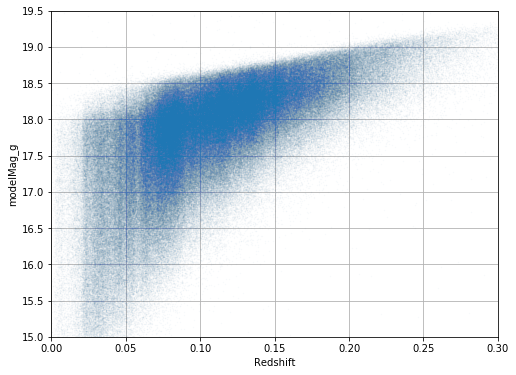

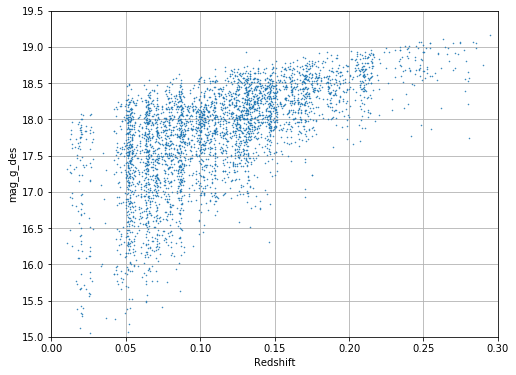

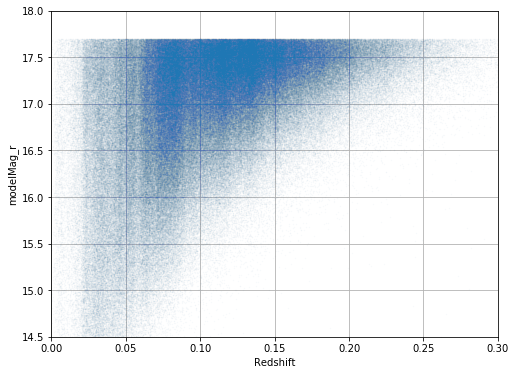

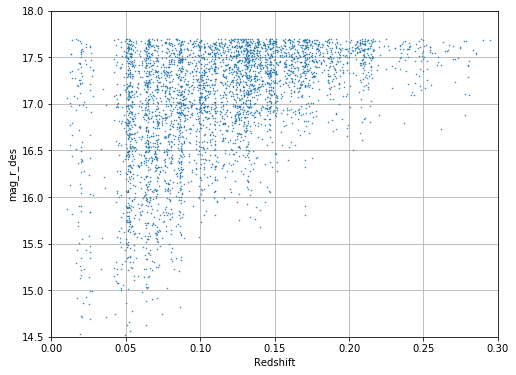

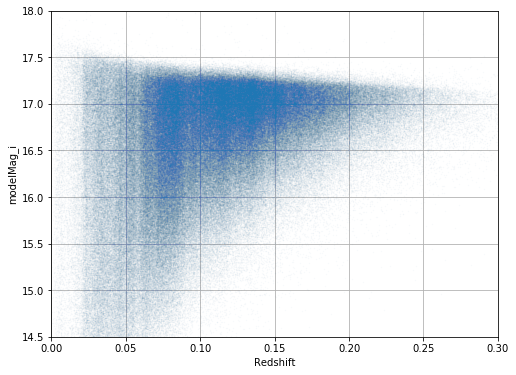

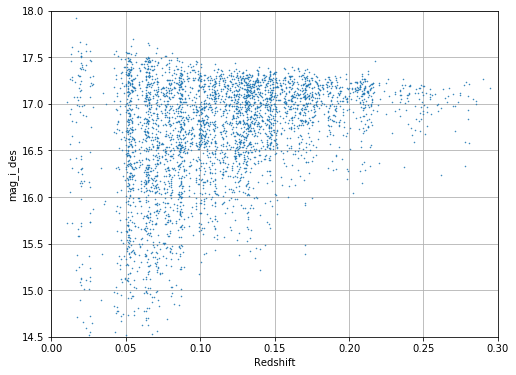

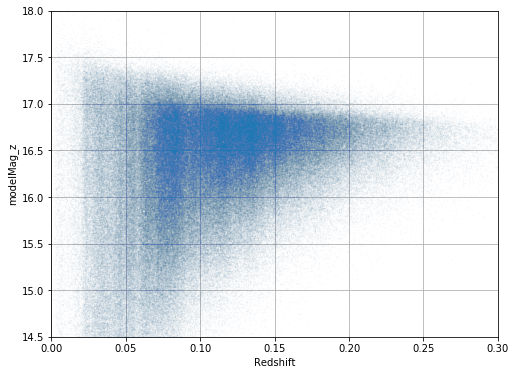

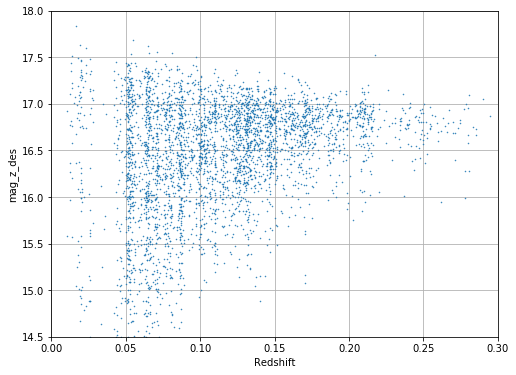

In [8]:
ylim_list = [[15, 19.5], [14.5, 18], [14.5, 18], [14.5, 18]]

for index in range(len(mock_mag_list)):
                 
    mock_mag = mock_mag_list[index]
    sdss_mag = sdss_mag_list[index]
    
    plt.figure(figsize=(8, 6))
    plt.plot(sdss['z'][mask_sdss], sdss[sdss_mag][mask_sdss], '.', markersize=0.25, alpha=0.1)
    plt.xlim([0., 0.3])
    plt.ylim(ylim_list[index])
    plt.xlabel('Redshift')
    plt.ylabel(sdss_mag)
    plt.grid()
    
    plt.figure(figsize=(8, 6))
    plt.plot(data['redshift_true'][mask_mock], data[mock_mag][mask_mock], '.', markersize=1, alpha=1)
    plt.xlim([0., 0.3])
    plt.ylim(ylim_list[index])
    plt.xlabel('Redshift')
    plt.ylabel(mock_mag)
    plt.grid()

/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in subtract


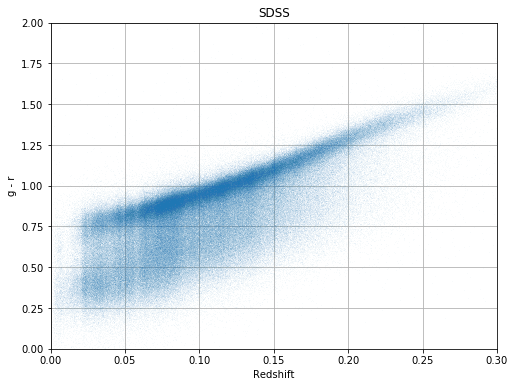

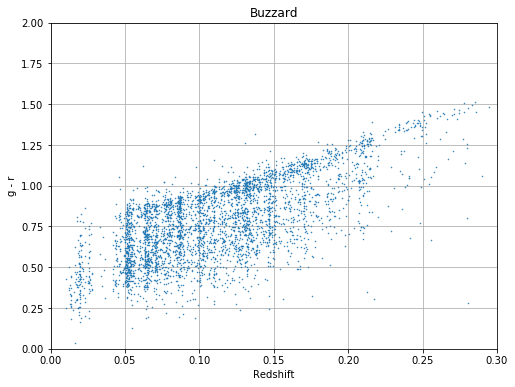

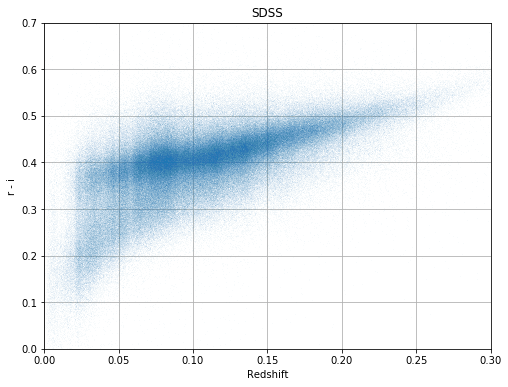

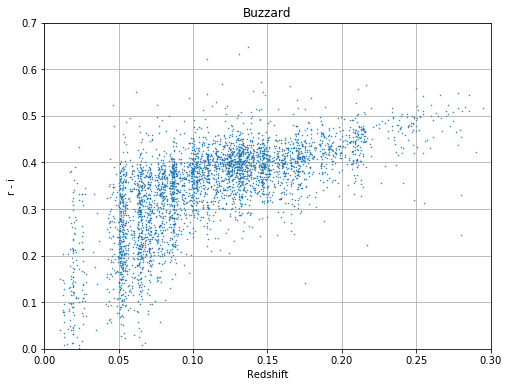

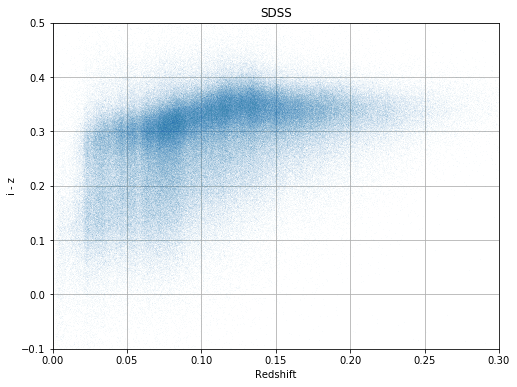

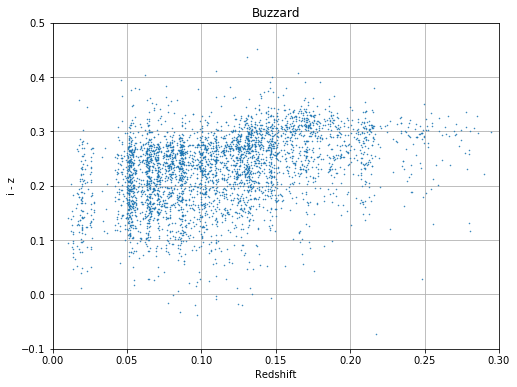

In [9]:
ylim_list = [[0, 2.], [0, 0.7], [-0.1, 0.5]]

for index in range(len(mock_mag_list)-1):
    
    sdss_mag1 = sdss_mag_list[index]
    sdss_mag2 = sdss_mag_list[index+1]
    plt.figure(figsize=(8, 6))
    plt.plot(sdss['z'][mask_sdss], (sdss[sdss_mag1][mask_sdss]-sdss[sdss_mag2][mask_sdss]), '.', markersize=0.2, alpha=0.1)
    plt.xlim(0., 0.3)
    plt.ylim(ylim_list[index])
    plt.xlabel('Redshift')
    plt.ylabel(sdss_mag1[-1]+' - '+sdss_mag2[-1])
    plt.title('SDSS')
    plt.grid()
    plt.savefig('/global/homes/r/rongpu/temp/descqa2/Buzzard_sdss_'+sdss_mag1[-1]+'-'+sdss_mag2[-1]+'_sdss.png')
    
    mock_mag1 = mock_mag_list[index]
    mock_mag2 = mock_mag_list[index+1]
    plt.figure(figsize=(8, 6))
    plt.plot(data['redshift_true'][mask_mock], data[mock_mag1][mask_mock]-data[mock_mag2][mask_mock], '.', markersize=1, alpha=1)
    plt.xlim(0., 0.3)
    plt.ylim(ylim_list[index])
    plt.xlabel('Redshift')
    plt.ylabel(mock_mag1[-5]+' - '+mock_mag2[-5])
    plt.title('Buzzard')
    plt.grid()
    plt.savefig('/global/homes/r/rongpu/temp/descqa2/Buzzard_sdss_'+mock_mag1[-5]+'-'+mock_mag2[-5]+'.png')

__Color transformation:__

In [10]:
data = color_transformation(data, validation_name='SDSS', mock_name='buzzard_test')

/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in subtract
/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in subtract


In [11]:
mask_mock = data['mag_r_sdss']<17.7
mock_mag_list = ['mag_g_sdss', 'mag_r_sdss', 'mag_i_sdss', 'mag_z_sdss']

/global/common/software/lsst/common/miniconda/py3-4.2.12/lib/python3.6/site-packages/astropy/table/column.py:928: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, oper)(other)


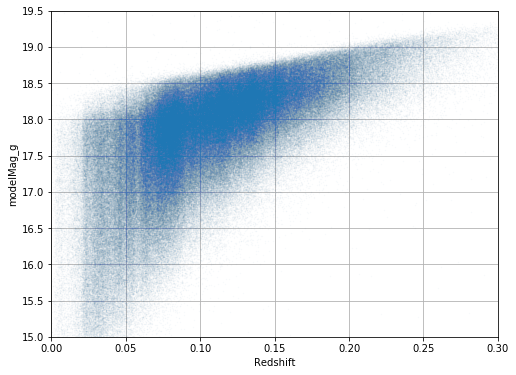

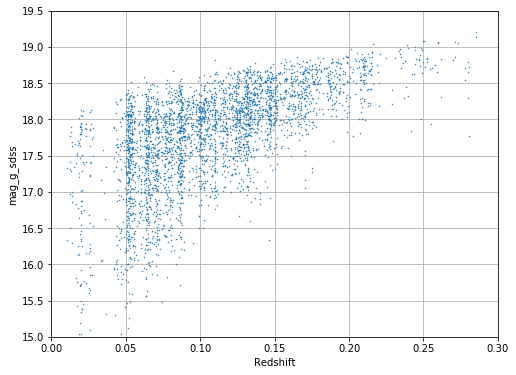

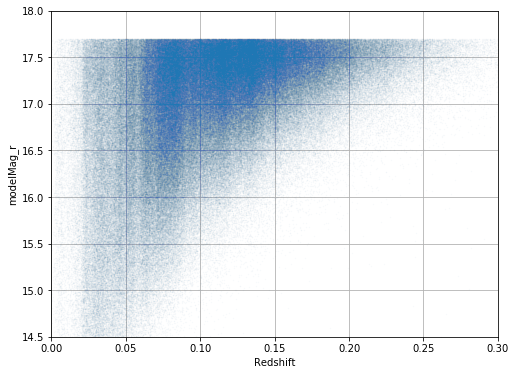

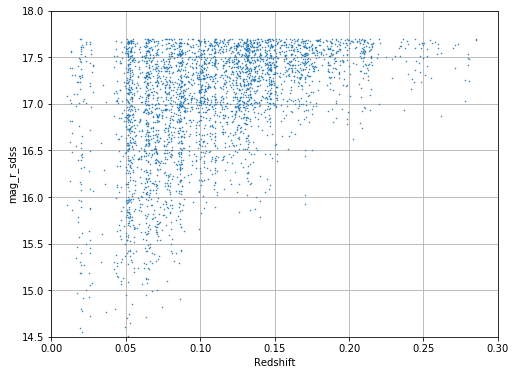

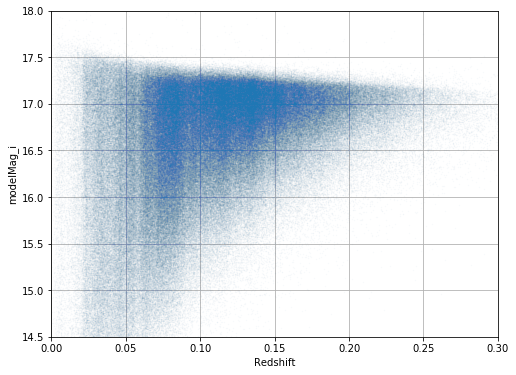

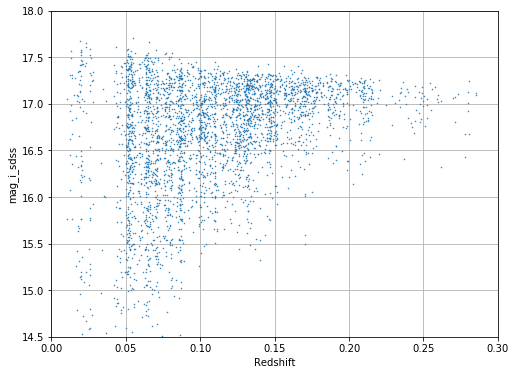

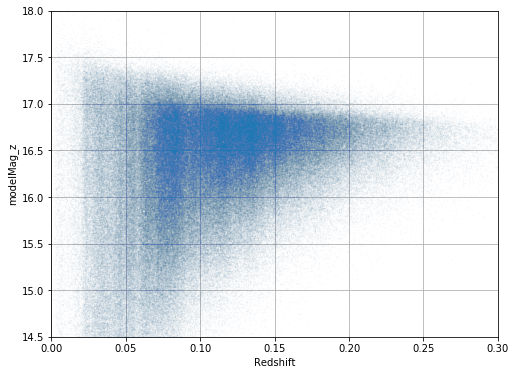

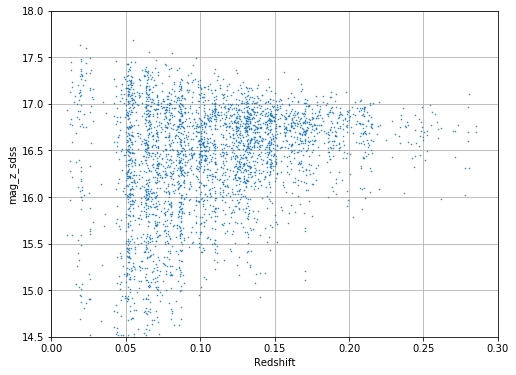

In [12]:
ylim_list = [[15, 19.5], [14.5, 18], [14.5, 18], [14.5, 18]]

for index in range(len(mock_mag_list)):
                 
    mock_mag = mock_mag_list[index]
    sdss_mag = sdss_mag_list[index]
    
    plt.figure(figsize=(8, 6))
    plt.plot(sdss['z'][mask_sdss], sdss[sdss_mag][mask_sdss], '.', markersize=0.25, alpha=0.1)
    plt.xlim([0., 0.3])
    plt.ylim(ylim_list[index])
    plt.xlabel('Redshift')
    plt.ylabel(sdss_mag)
    plt.grid()
    
    plt.figure(figsize=(8, 6))
    plt.plot(data['redshift_true'][mask_mock], data[mock_mag][mask_mock], '.', markersize=1, alpha=1)
    plt.xlim([0., 0.3])
    plt.ylim(ylim_list[index])
    plt.xlabel('Redshift')
    plt.ylabel(mock_mag)
    plt.grid()

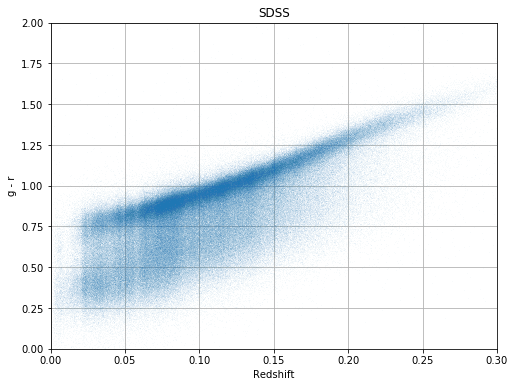

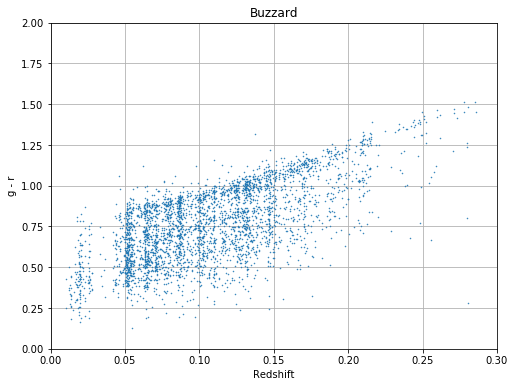

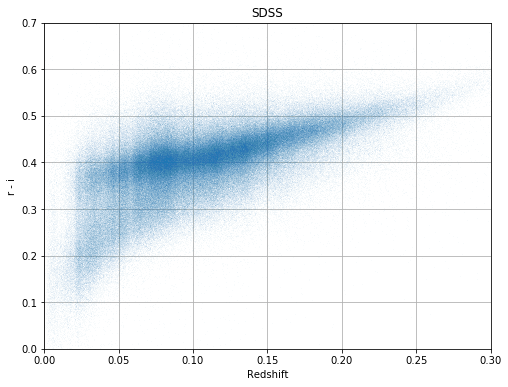

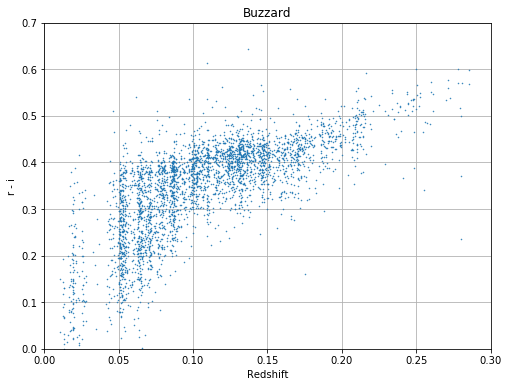

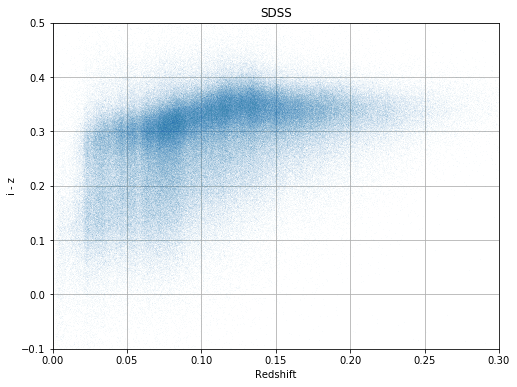

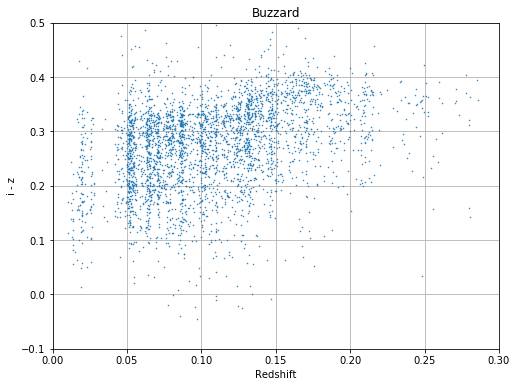

In [13]:
ylim_list = [[0, 2.], [0, 0.7], [-0.1, 0.5]]

for index in range(len(mock_mag_list)-1):
    
    sdss_mag1 = sdss_mag_list[index]
    sdss_mag2 = sdss_mag_list[index+1]
    plt.figure(figsize=(8, 6))
    plt.plot(sdss['z'][mask_sdss], (sdss[sdss_mag1][mask_sdss]-sdss[sdss_mag2][mask_sdss]), '.', markersize=0.2, alpha=0.1)
    plt.xlim(0., 0.3)
    plt.ylim(ylim_list[index])
    plt.xlabel('Redshift')
    plt.ylabel(sdss_mag1[-1]+' - '+sdss_mag2[-1])
    plt.title('SDSS')
    plt.grid()
    # plt.savefig('/global/homes/r/rongpu/temp/descqa2/Buzzard_sdss_'+sdss_mag1[-1]+'-'+sdss_mag2[-1]+'_sdss.png')
    
    mock_mag1 = mock_mag_list[index]
    mock_mag2 = mock_mag_list[index+1]
    plt.figure(figsize=(8, 6))
    plt.plot(data['redshift_true'][mask_mock], data[mock_mag1][mask_mock]-data[mock_mag2][mask_mock], '.', markersize=1, alpha=1)
    plt.xlim(0., 0.3)
    plt.ylim(ylim_list[index])
    plt.xlabel('Redshift')
    plt.ylabel(mock_mag1[-6]+' - '+mock_mag2[-6])
    plt.title('Buzzard')
    plt.grid()
    plt.savefig('/global/homes/r/rongpu/temp/descqa2/Buzzard_sdss_'+mock_mag1[-6]+'-'+mock_mag2[-6]+'_transformed.png')

----------
## DEEP2+3

In [14]:
deep2 = Table.read('/global/homes/r/rongpu/data/descqa2/DEEP2_uniq_Terapix_Subaru.fits')
print(len(deep2))
mask = deep2['zquality']>=3
deep2 = deep2[mask]
print(len(deep2))

mock_mag_list = ['mag_g_des', 'mag_r_des', 'mag_i_des', 'mag_z_des']
deep2_mag_list = ['g_apercor', 'r_apercor', 'i_apercor', 'z_apercor']
# deep2_mag_list = ['u', 'g', 'r', 'i', 'z']

23822
16857


In [15]:
print(' '.join(deep2.colnames))

ra dec objno_deep2 ra_deep2 dec_deep2 magb magr magi pgal sfd_ebv class subclass objname maskname slitname date mjd z_raw zhelio z_err rchi2 dof vdisp vdisp_err zquality egsflags comment m_b ub_0 ra_cfhtls dec_cfhtls u g r i i2 z uerr gerr rerr ierr i2err zerr u_apercor g_apercor r_apercor i_apercor i2_apercor z_apercor uerr_aper gerr_aper rerr_aper ierr_aper i2err_aper zerr_aper uerr_apercor gerr_apercor rerr_apercor ierr_apercor i2err_apercor zerr_apercor r_radius_arcsec u(SExflag) g(SExflag) r(SExflag) i(SExflag) i2(SExflag) z(SExflag) flag_cfhtls cfhtls_source ra_subaru dec_subaru y yerr y_apercor yerr_aper yerr_apercor y(SExflag) y_radius_arcsec subaru_source


In [16]:
mask_mock = data['mag_r_des']<24.0
mask_deep2 = deep2['r_apercor']<24.0

mask_all = np.ones(len(deep2), dtype=bool)
for deep2_mag in deep2_mag_list:
    mask = (deep2[deep2_mag]>=0) & (deep2[deep2_mag]<50)
    print('Invalid '+deep2_mag+':', np.sum(~mask[mask_deep2]))
    mask_all &= mask
print('{} ({:.2f})% objects removed due to invalide magnitudes'\
      .format(np.sum(~mask_all), np.sum(~mask_all[mask_deep2])/np.sum(mask_deep2)*100))

mask_deep2 &= mask_all

Invalid g_apercor: 275
Invalid r_apercor: 274
Invalid i_apercor: 277
Invalid z_apercor: 276
488 (1.90)% objects removed due to invalide magnitudes


/global/common/software/lsst/common/miniconda/py3-4.2.12/lib/python3.6/site-packages/astropy/table/column.py:928: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, oper)(other)


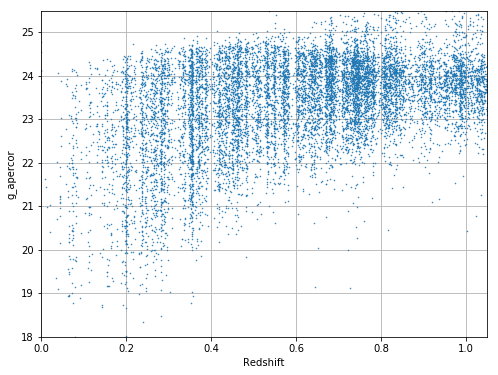

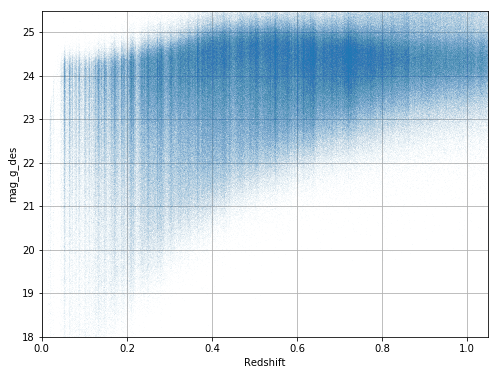

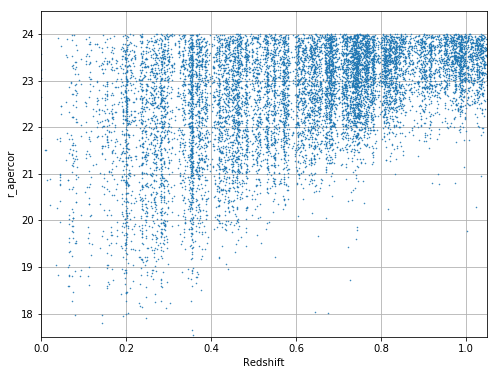

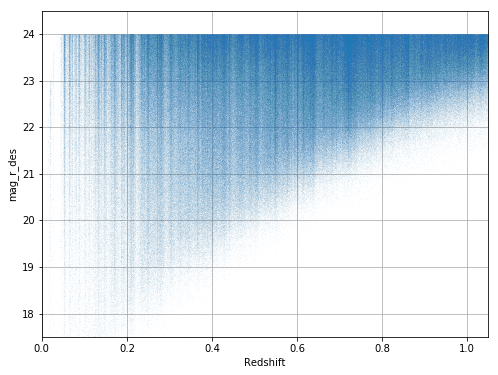

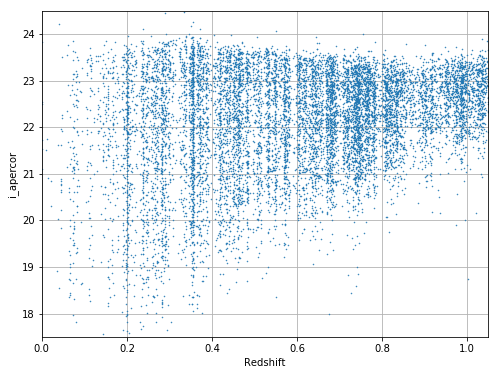

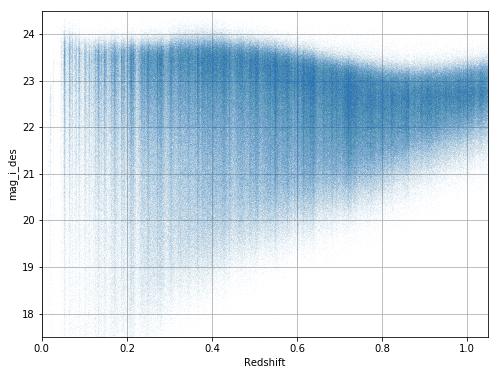

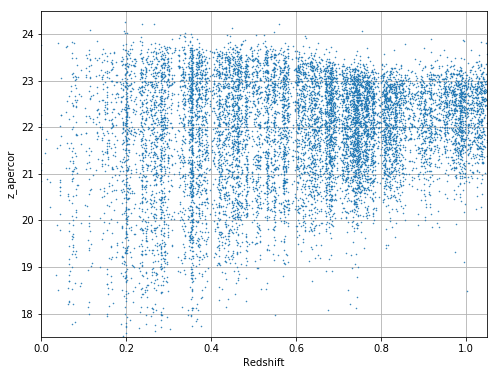

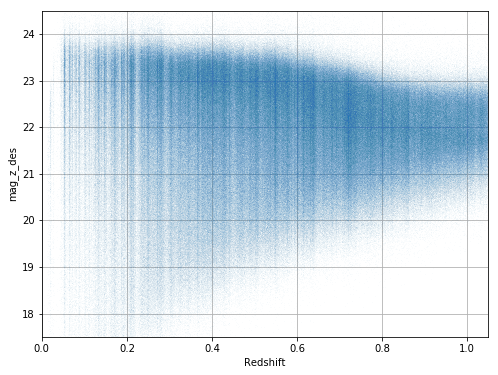

In [17]:
ylim_list = [[18, 25.5], [17.5, 24.5], [17.5, 24.5], [17.5, 24.5]]

for index in range(len(mock_mag_list)):
                 
    mock_mag = mock_mag_list[index]
    deep2_mag = deep2_mag_list[index]
    
    plt.figure(figsize=(8, 6))
    plt.plot(deep2['zhelio'][mask_deep2], deep2[deep2_mag][mask_deep2], '.', markersize=1, alpha=1)
    plt.xlim([0., 1.05])
    plt.ylim(ylim_list[index])
    plt.xlabel('Redshift')
    plt.ylabel(deep2_mag)
    plt.grid()
    
    plt.figure(figsize=(8, 6))
    plt.plot(data['redshift_true'][mask_mock], data[mock_mag][mask_mock], '.', markersize=0.15, alpha=0.1)
    plt.xlim([0., 1.05])
    plt.ylim(ylim_list[index])
    plt.xlabel('Redshift')
    plt.ylabel(mock_mag)
    plt.grid()

/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in subtract


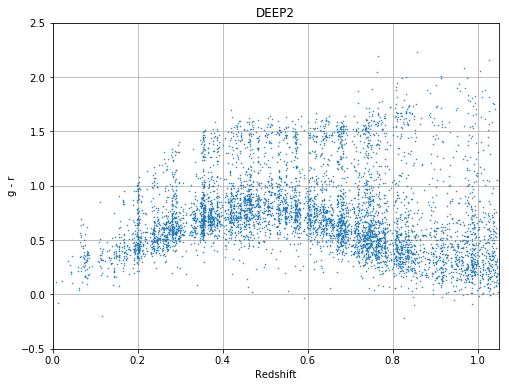

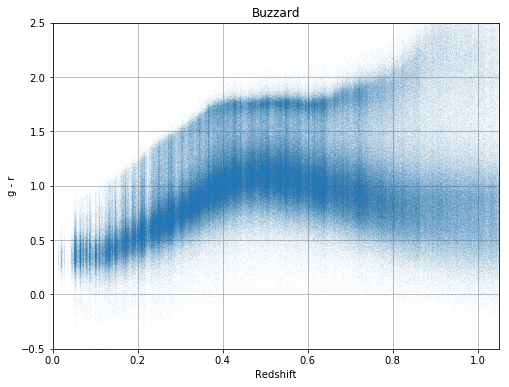

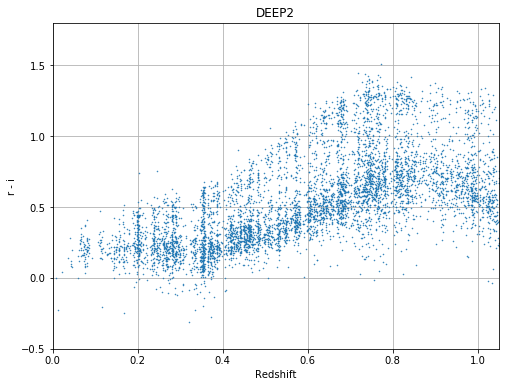

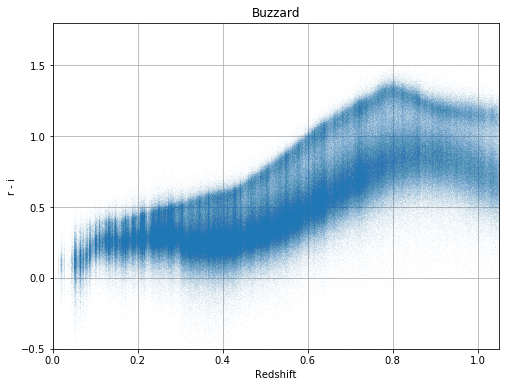

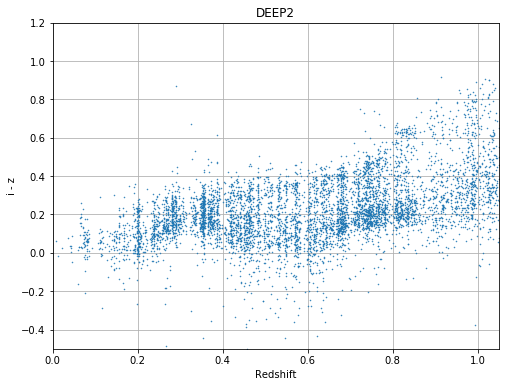

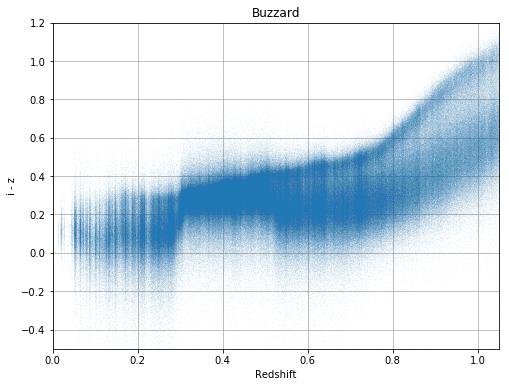

In [18]:
ylim_list = [[-0.5, 2.5], [-0.5, 1.8], [-0.5, 1.2]]

for index in range(len(mock_mag_list)-1):
    
    deep2_mag1 = deep2_mag_list[index]
    deep2_mag2 = deep2_mag_list[index+1]
    plt.figure(figsize=(8, 6))
    plt.plot(deep2['zhelio'][mask_deep2][::2], (deep2[deep2_mag1][mask_deep2]-deep2[deep2_mag2][mask_deep2])[::2], '.', markersize=1, alpha=1)
    plt.xlim(0., 1.05)
    plt.ylim(ylim_list[index])
    plt.xlabel('Redshift')
    plt.ylabel(deep2_mag1[0]+' - '+deep2_mag2[0])
    plt.title('DEEP2')
    plt.grid()
    plt.savefig('/global/homes/r/rongpu/temp/descqa2/Buzzard_deep2_'+deep2_mag1[0]+'-'+deep2_mag2[0]+'_deep2.png')
    
    mock_mag1 = mock_mag_list[index]
    mock_mag2 = mock_mag_list[index+1]
    plt.figure(figsize=(8, 6))
    plt.plot(data['redshift_true'][mask_mock], data[mock_mag1][mask_mock]-data[mock_mag2][mask_mock], '.', markersize=0.15, alpha=0.1)
    plt.xlim(0., 1.05)
    plt.ylim(ylim_list[index])
    plt.xlabel('Redshift')
    plt.ylabel(mock_mag1[-5]+' - '+mock_mag2[-5])
    plt.title('Buzzard')
    plt.grid()
    plt.savefig('/global/homes/r/rongpu/temp/descqa2/Buzzard_deep2_'+mock_mag1[-5]+'-'+mock_mag2[-5]+'.png')

__Color transformation:__

In [19]:
data = color_transformation(data, validation_name='DEEP2', mock_name='buzzard_test')

/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in subtract


In [20]:
data.colnames

['mag_g_des',
 'mag_i_des',
 'redshift_true',
 'mag_Y_des',
 'ra',
 'dec',
 'mag_z_des',
 'mag_r_des',
 'mag_g_sdss',
 'mag_r_sdss',
 'mag_i_sdss',
 'mag_z_sdss',
 'mag_g_cfht',
 'mag_r_cfht',
 'mag_i_cfht',
 'mag_z_cfht']

In [21]:
mask_mock = data['mag_r_cfht']<24.0
mock_mag_list = ['mag_g_cfht', 'mag_r_cfht', 'mag_i_cfht', 'mag_z_cfht']

/global/common/software/lsst/common/miniconda/py3-4.2.12/lib/python3.6/site-packages/astropy/table/column.py:928: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, oper)(other)


/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in subtract


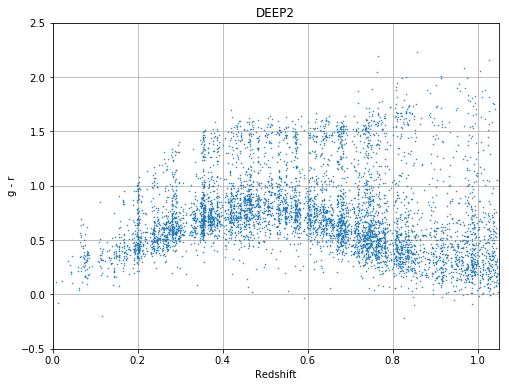

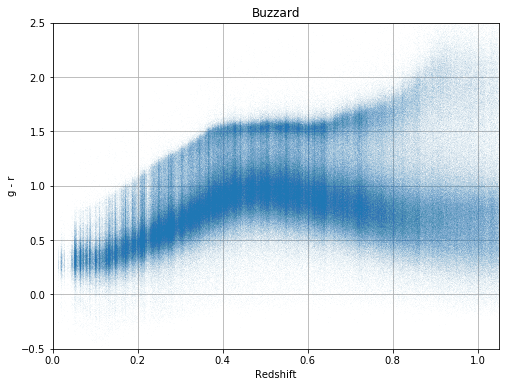

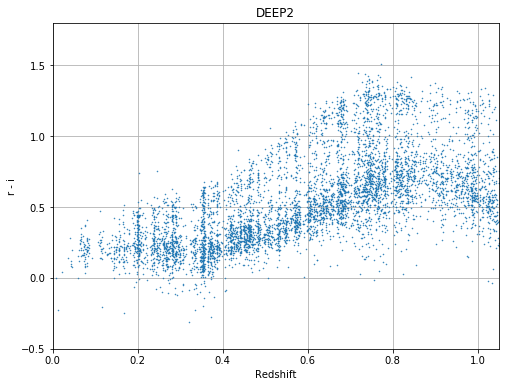

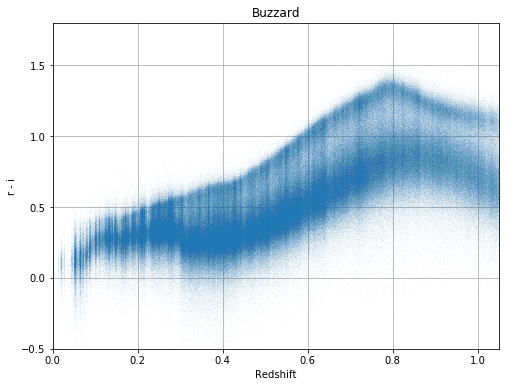

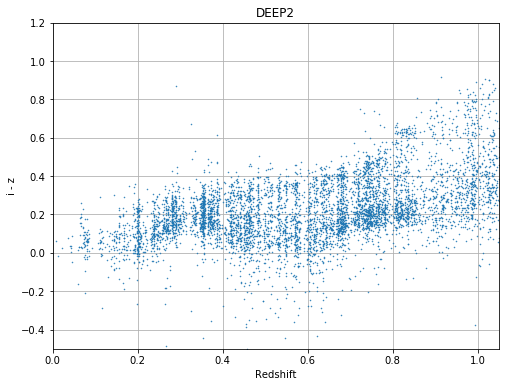

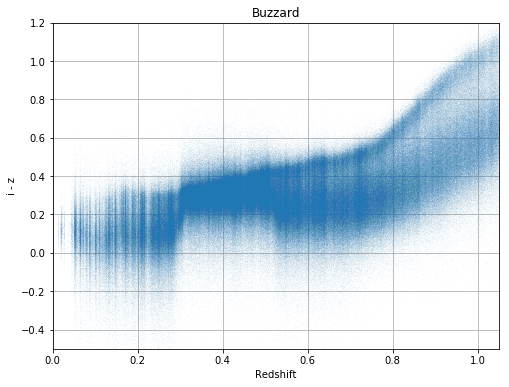

In [22]:
ylim_list = [[-0.5, 2.5], [-0.5, 1.8], [-0.5, 1.2]]

for index in range(len(mock_mag_list)-1):
    
    deep2_mag1 = deep2_mag_list[index]
    deep2_mag2 = deep2_mag_list[index+1]
    plt.figure(figsize=(8, 6))
    plt.plot(deep2['zhelio'][mask_deep2][::2], (deep2[deep2_mag1][mask_deep2]-deep2[deep2_mag2][mask_deep2])[::2], '.', markersize=1, alpha=1)
    plt.xlim(0., 1.05)
    plt.ylim(ylim_list[index])
    plt.xlabel('Redshift')
    plt.ylabel(deep2_mag1[0]+' - '+deep2_mag2[0])
    plt.title('DEEP2')
    plt.grid()
    # plt.savefig('/global/homes/r/rongpu/temp/descqa2/Buzzard_deep2_'+deep2_mag1[0]+'-'+deep2_mag2[0]+'_deep2.png')
    
    mock_mag1 = mock_mag_list[index]
    mock_mag2 = mock_mag_list[index+1]
    plt.figure(figsize=(8, 6))
    plt.plot(data['redshift_true'][mask_mock], data[mock_mag1][mask_mock]-data[mock_mag2][mask_mock], '.', markersize=0.15, alpha=0.1)
    plt.xlim(0., 1.05)
    plt.ylim(ylim_list[index])
    plt.xlabel('Redshift')
    plt.ylabel(mock_mag1[-6]+' - '+mock_mag2[-6])
    plt.title('Buzzard')
    plt.grid()
    plt.savefig('/global/homes/r/rongpu/temp/descqa2/Buzzard_deep2_'+mock_mag1[-6]+'-'+mock_mag2[-6]+'_transformed.png')